In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 831)
(734160, 1)
validation
(101248, 831)
(101248, 1)
test
(100432, 831)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:30 - loss: 0.1710 - STD: 1.4439e-04 - MAE: 0.4022

 4/74 [>.............................] - ETA: 1s - loss: 0.0568 - STD: 3.5250e-04 - MAE: 0.1820  

 7/74 [=>............................] - ETA: 1s - loss: 0.0433 - STD: 2.4277e-04 - MAE: 0.1591

10/74 [===>..........................] - ETA: 1s - loss: 0.0394 - STD: 1.7734e-04 - MAE: 0.1550

13/74 [====>.........................] - ETA: 1s - loss: 0.0372 - STD: 1.3819e-04 - MAE: 0.1527

16/74 [=====>........................] - ETA: 1s - loss: 0.0353 - STD: 1.1490e-04 - MAE: 0.1492

19/74 [======>.......................] - ETA: 0s - loss: 0.0331 - STD: 1.0127e-04 - MAE: 0.1436

23/74 [========>.....................] - ETA: 0s - loss: 0.0296 - STD: 9.2671e-05 - MAE: 0.1333

27/74 [=========>....................] - ETA: 0s - loss: 0.0267 - STD: 8.8706e-05 - MAE: 0.1253

30/74 [===========>..................] - ETA: 0s - loss: 0.0252 - STD: 8.5845e-05 - MAE: 0.1222

33/74 [============>.................] - ETA: 0s - loss: 0.0240 - STD: 8.2246e-05 - MAE: 0.1195

37/74 [==============>...............] - ETA: 0s - loss: 0.0224 - STD: 7.6754e-05 - MAE: 0.1150

41/74 [===============>..............] - ETA: 0s - loss: 0.0212 - STD: 7.1226e-05 - MAE: 0.1110

45/74 [=================>............] - ETA: 0s - loss: 0.0204 - STD: 6.6511e-05 - MAE: 0.1077

49/74 [==================>...........] - ETA: 0s - loss: 0.0195 - STD: 6.2687e-05 - MAE: 0.1050

53/74 [====================>.........] - ETA: 0s - loss: 0.0187 - STD: 5.9531e-05 - MAE: 0.1028

57/74 [======================>.......] - ETA: 0s - loss: 0.0180 - STD: 5.6900e-05 - MAE: 0.1011

60/74 [=======================>......] - ETA: 0s - loss: 0.0176 - STD: 5.5169e-05 - MAE: 0.0999

64/74 [========================>.....] - ETA: 0s - loss: 0.0171 - STD: 5.3165e-05 - MAE: 0.0984

67/74 [==========================>...] - ETA: 0s - loss: 0.0167 - STD: 5.1884e-05 - MAE: 0.0973

71/74 [===========================>..] - ETA: 0s - loss: 0.0163 - STD: 5.0412e-05 - MAE: 0.0961

74/74 [==============================] - 4s 33ms/step - loss: 0.0160 - STD: 4.9433e-05 - MAE: 0.0953 - val_loss: 0.0086 - val_STD: 1.9353e-05 - val_MAE: 0.0718


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0091 - STD: 2.7968e-05 - MAE: 0.0753

 4/74 [>.............................] - ETA: 1s - loss: 0.0093 - STD: 2.8314e-05 - MAE: 0.0761

 8/74 [==>...........................] - ETA: 1s - loss: 0.0092 - STD: 2.9123e-05 - MAE: 0.0761

11/74 [===>..........................] - ETA: 1s - loss: 0.0092 - STD: 2.9442e-05 - MAE: 0.0760

14/74 [====>.........................] - ETA: 1s - loss: 0.0092 - STD: 3.0280e-05 - MAE: 0.0758

18/74 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 3.1386e-05 - MAE: 0.0756

22/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 3.2360e-05 - MAE: 0.0756

25/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 3.3170e-05 - MAE: 0.0756

28/74 [==========>...................] - ETA: 0s - loss: 0.0092 - STD: 3.4076e-05 - MAE: 0.0756

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 3.4956e-05 - MAE: 0.0756

34/74 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 3.6069e-05 - MAE: 0.0755

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 3.7314e-05 - MAE: 0.0755

40/74 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 3.8486e-05 - MAE: 0.0755

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 3.9657e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 4.0862e-05 - MAE: 0.0754

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 4.2106e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 4.3398e-05 - MAE: 0.0755

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 4.5244e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.7224e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.8869e-05 - MAE: 0.0755

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.0627e-05 - MAE: 0.0755

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 5.3144e-05 - MAE: 0.0755

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 5.5818e-05 - MAE: 0.0755

74/74 [==============================] - 2s 20ms/step - loss: 0.0092 - STD: 5.5818e-05 - MAE: 0.0755 - val_loss: 0.0086 - val_STD: 6.8986e-05 - val_MAE: 0.0714


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0091 - STD: 1.0762e-04 - MAE: 0.0752

 4/74 [>.............................] - ETA: 1s - loss: 0.0092 - STD: 1.1070e-04 - MAE: 0.0753

 8/74 [==>...........................] - ETA: 1s - loss: 0.0092 - STD: 1.1606e-04 - MAE: 0.0752

11/74 [===>..........................] - ETA: 1s - loss: 0.0092 - STD: 1.2067e-04 - MAE: 0.0752

14/74 [====>.........................] - ETA: 1s - loss: 0.0092 - STD: 1.2561e-04 - MAE: 0.0752

17/74 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 1.3061e-04 - MAE: 0.0752

20/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 1.3595e-04 - MAE: 0.0752

23/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 1.4170e-04 - MAE: 0.0752

27/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 1.4967e-04 - MAE: 0.0752

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 1.5851e-04 - MAE: 0.0752

35/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 1.6826e-04 - MAE: 0.0752

39/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 1.7868e-04 - MAE: 0.0751

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.9053e-04 - MAE: 0.0752

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 2.0405e-04 - MAE: 0.0753

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 2.1899e-04 - MAE: 0.0753

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 2.3114e-04 - MAE: 0.0753

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 2.4930e-04 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.6968e-04 - MAE: 0.0753

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.9272e-04 - MAE: 0.0753

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.1938e-04 - MAE: 0.0753

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 3.4981e-04 - MAE: 0.0753

74/74 [==============================] - 1s 20ms/step - loss: 0.0092 - STD: 3.4981e-04 - MAE: 0.0753 - val_loss: 0.0085 - val_STD: 6.3444e-04 - val_MAE: 0.0713


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0091 - STD: 9.7457e-04 - MAE: 0.0751

 4/74 [>.............................] - ETA: 1s - loss: 0.0090 - STD: 0.0010 - MAE: 0.0749    

 7/74 [=>............................] - ETA: 1s - loss: 0.0090 - STD: 0.0011 - MAE: 0.0748

10/74 [===>..........................] - ETA: 1s - loss: 0.0090 - STD: 0.0012 - MAE: 0.0748

13/74 [====>.........................] - ETA: 1s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0748

16/74 [=====>........................] - ETA: 1s - loss: 0.0090 - STD: 0.0014 - MAE: 0.0747

20/74 [=======>......................] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0748

23/74 [========>.....................] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

26/74 [=========>....................] - ETA: 0s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0749

29/74 [==========>...................] - ETA: 0s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0749

32/74 [===========>..................] - ETA: 0s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0749

35/74 [=============>................] - ETA: 0s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0747

39/74 [==============>...............] - ETA: 0s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0746

42/74 [================>.............] - ETA: 0s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0745

45/74 [=================>............] - ETA: 0s - loss: 0.0089 - STD: 0.0033 - MAE: 0.0744

48/74 [==================>...........] - ETA: 0s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0743

52/74 [====================>.........] - ETA: 0s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0741

56/74 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0740

60/74 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0738

63/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0736

67/74 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0733

70/74 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0731

74/74 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0091 - MAE: 0.0728

74/74 [==============================] - 1s 19ms/step - loss: 0.0086 - STD: 0.0091 - MAE: 0.0728 - val_loss: 0.0066 - val_STD: 0.0190 - val_MAE: 0.0631


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.0308 - MAE: 0.0674

 4/74 [>.............................] - ETA: 1s - loss: 0.0072 - STD: 0.0321 - MAE: 0.0668

 7/74 [=>............................] - ETA: 1s - loss: 0.0072 - STD: 0.0333 - MAE: 0.0667

10/74 [===>..........................] - ETA: 1s - loss: 0.0071 - STD: 0.0345 - MAE: 0.0664

13/74 [====>.........................] - ETA: 1s - loss: 0.0071 - STD: 0.0355 - MAE: 0.0661

16/74 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.0364 - MAE: 0.0659

20/74 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0375 - MAE: 0.0653

24/74 [========>.....................] - ETA: 0s - loss: 0.0069 - STD: 0.0384 - MAE: 0.0649

27/74 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0392 - MAE: 0.0647

31/74 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0402 - MAE: 0.0644

35/74 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0412 - MAE: 0.0641

39/74 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0421 - MAE: 0.0637

42/74 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0427 - MAE: 0.0635

45/74 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0433 - MAE: 0.0633

48/74 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0438 - MAE: 0.0630

51/74 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0443 - MAE: 0.0628

55/74 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0449 - MAE: 0.0624

58/74 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0453 - MAE: 0.0622

62/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0460 - MAE: 0.0619

65/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0464 - MAE: 0.0617

68/74 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0468 - MAE: 0.0615

72/74 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0474 - MAE: 0.0612

74/74 [==============================] - 1s 20ms/step - loss: 0.0062 - STD: 0.0477 - MAE: 0.0611 - val_loss: 0.0048 - val_STD: 0.0479 - val_MAE: 0.0540


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0579

 4/74 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0567

 8/74 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0564

12/74 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0561

15/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0560

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0560

22/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0558

26/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0557

30/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0556

33/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0555

37/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0555

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0554

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0553

49/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0552

53/74 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0552

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0551

59/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0550

62/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0550

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0549

68/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0549

71/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0548

74/74 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0548

74/74 [==============================] - 1s 20ms/step - loss: 0.0051 - STD: 0.0605 - MAE: 0.0548 - val_loss: 0.0045 - val_STD: 0.0531 - val_MAE: 0.0522


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0546

 5/74 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0627 - MAE: 0.0538

 9/74 [==>...........................] - ETA: 0s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0537

13/74 [====>.........................] - ETA: 0s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0535

16/74 [=====>........................] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0536

19/74 [======>.......................] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0536

22/74 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0535

26/74 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0534

29/74 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0534

33/74 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0533

36/74 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0532

40/74 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0533

44/74 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0535

47/74 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0537

51/74 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0538

55/74 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0538

58/74 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0537

61/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0537

65/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0536

68/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0536

72/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0535

74/74 [==============================] - 1s 19ms/step - loss: 0.0049 - STD: 0.0630 - MAE: 0.0535 - val_loss: 0.0043 - val_STD: 0.0557 - val_MAE: 0.0509


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0535

 4/74 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0522

 7/74 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0522

10/74 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0523

14/74 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

18/74 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

21/74 [=======>......................] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

25/74 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0521

28/74 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

32/74 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0520

36/74 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0520

39/74 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0519

42/74 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

45/74 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0519

48/74 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0519

51/74 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

54/74 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

57/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0518

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0518

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0518

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0518

74/74 [==============================] - 1s 19ms/step - loss: 0.0046 - STD: 0.0659 - MAE: 0.0518 - val_loss: 0.0040 - val_STD: 0.0538 - val_MAE: 0.0477


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0515

 4/74 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0522

 7/74 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0656 - MAE: 0.0524

11/74 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0659 - MAE: 0.0530

14/74 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0655 - MAE: 0.0531

17/74 [=====>........................] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0528

20/74 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0527

24/74 [========>.....................] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0527

27/74 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0526

31/74 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0525

35/74 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0523

39/74 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0522

42/74 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0521

46/74 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0520

49/74 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0658 - MAE: 0.0519

52/74 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0519

55/74 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0518

58/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0518

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0517

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0516

74/74 [==============================] - 1s 19ms/step - loss: 0.0046 - STD: 0.0663 - MAE: 0.0516 - val_loss: 0.0042 - val_STD: 0.0579 - val_MAE: 0.0504


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0518

 4/74 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

 8/74 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509

11/74 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

15/74 [=====>........................] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

18/74 [======>.......................] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

21/74 [=======>......................] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

25/74 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

29/74 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

32/74 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

36/74 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

39/74 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

43/74 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

47/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509

50/74 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0510

54/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

57/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

74/74 [==============================] - 1s 20ms/step - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511 - val_loss: 0.0039 - val_STD: 0.0577 - val_MAE: 0.0485


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0514

 4/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

 7/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

10/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0502

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

17/74 [=====>........................] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

21/74 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

24/74 [========>.....................] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

28/74 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

32/74 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0501

36/74 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0501

39/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0501

43/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

50/74 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

53/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

56/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0500

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0500

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0500

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

74/74 [==============================] - 1s 19ms/step - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500 - val_loss: 0.0040 - val_STD: 0.0598 - val_MAE: 0.0490


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0504

 4/74 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0500

 8/74 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

11/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

15/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

19/74 [======>.......................] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

23/74 [========>.....................] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

26/74 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0497

29/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

32/74 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

36/74 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

40/74 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

43/74 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

46/74 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

49/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

52/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0496

55/74 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

74/74 [==============================] - 1s 20ms/step - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495 - val_loss: 0.0039 - val_STD: 0.0531 - val_MAE: 0.0452


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0644 - MAE: 0.0489

 5/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0499

 8/74 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

12/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0496

15/74 [=====>........................] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0496

18/74 [======>.......................] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0496

22/74 [=======>......................] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

25/74 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

29/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

33/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

36/74 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0499

40/74 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

43/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0500

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

50/74 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500

53/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500

56/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0499

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0498

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0498

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0498

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0497

74/74 [==============================] - 1s 19ms/step - loss: 0.0043 - STD: 0.0687 - MAE: 0.0497 - val_loss: 0.0037 - val_STD: 0.0564 - val_MAE: 0.0448


Epoch 14/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0482

 4/74 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0485

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0487

11/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0489

14/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

17/74 [=====>........................] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

20/74 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

24/74 [========>.....................] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0491

28/74 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

31/74 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

34/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

38/74 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

41/74 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

44/74 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

47/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

50/74 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

53/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

57/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0493

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

74/74 [==============================] - 1s 20ms/step - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492 - val_loss: 0.0036 - val_STD: 0.0581 - val_MAE: 0.0449


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0482

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0482

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0481

11/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0483

15/74 [=====>........................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

19/74 [======>.......................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0484

23/74 [========>.....................] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

26/74 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

30/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

34/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

38/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

42/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

46/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

49/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

52/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

74/74 [==============================] - 1s 19ms/step - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485 - val_loss: 0.0035 - val_STD: 0.0562 - val_MAE: 0.0440


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0681 - MAE: 0.0474

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0483

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0483

10/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

13/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

16/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

20/74 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

24/74 [========>.....................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

28/74 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

31/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

34/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

37/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

40/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

43/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

46/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

49/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

52/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

55/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

74/74 [==============================] - 2s 20ms/step - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482 - val_loss: 0.0035 - val_STD: 0.0584 - val_MAE: 0.0442


Epoch 17/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

 8/74 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0480

12/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

15/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0480

18/74 [======>.......................] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0482

21/74 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

24/74 [========>.....................] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

28/74 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0486

31/74 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

35/74 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0485

39/74 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0485

42/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

45/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

49/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

52/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

55/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

74/74 [==============================] - 1s 20ms/step - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482 - val_loss: 0.0034 - val_STD: 0.0588 - val_MAE: 0.0438


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0469

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

 8/74 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

12/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

15/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

19/74 [======>.......................] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

22/74 [=======>......................] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

25/74 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

28/74 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0476

31/74 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

35/74 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

39/74 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

43/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

46/74 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

50/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

74/74 [==============================] - 1s 19ms/step - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476 - val_loss: 0.0035 - val_STD: 0.0611 - val_MAE: 0.0456


Epoch 19/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0488

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0473

 8/74 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

11/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

15/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

19/74 [======>.......................] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

23/74 [========>.....................] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

26/74 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

30/74 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

34/74 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

38/74 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

41/74 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

44/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

47/74 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

51/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

74/74 [==============================] - 1s 19ms/step - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475 - val_loss: 0.0039 - val_STD: 0.0540 - val_MAE: 0.0450


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0497

 5/74 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0489

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0486

12/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0484

15/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

18/74 [======>.......................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

21/74 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

24/74 [========>.....................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

27/74 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

31/74 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

34/74 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

38/74 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

41/74 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

44/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

48/74 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

51/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

74/74 [==============================] - 1s 20ms/step - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472 - val_loss: 0.0033 - val_STD: 0.0606 - val_MAE: 0.0431


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

 5/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

 8/74 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

12/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0468

15/74 [=====>........................] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

19/74 [======>.......................] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

22/74 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

25/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

31/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

35/74 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

39/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

43/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0470

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

50/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0471

53/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

56/74 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

74/74 [==============================] - 1s 20ms/step - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481 - val_loss: 0.0032 - val_STD: 0.0597 - val_MAE: 0.0435


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0476

 5/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0485

 8/74 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0481

11/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

17/74 [=====>........................] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

20/74 [=======>......................] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

24/74 [========>.....................] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

28/74 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

31/74 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

34/74 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

38/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

42/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

49/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

52/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

56/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

74/74 [==============================] - 1s 19ms/step - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0630 - val_MAE: 0.0435


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0470

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0463

 7/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

10/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

13/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

17/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

20/74 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

24/74 [========>.....................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

27/74 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

31/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

35/74 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

38/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

42/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

45/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

49/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

52/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

55/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

74/74 [==============================] - 1s 19ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461 - val_loss: 0.0035 - val_STD: 0.0571 - val_MAE: 0.0428


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0678 - MAE: 0.0459

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0460

 8/74 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

11/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

15/74 [=====>........................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

19/74 [======>.......................] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

22/74 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

26/74 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

29/74 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

32/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

36/74 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

40/74 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

43/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

50/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

54/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

74/74 [==============================] - 1s 19ms/step - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460 - val_loss: 0.0032 - val_STD: 0.0596 - val_MAE: 0.0422


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0448

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0712 - MAE: 0.0455

 8/74 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

12/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

15/74 [=====>........................] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

19/74 [======>.......................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

23/74 [========>.....................] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

27/74 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

30/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

33/74 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

36/74 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

39/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

42/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

49/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

52/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

55/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

74/74 [==============================] - 1s 19ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461 - val_loss: 0.0033 - val_STD: 0.0633 - val_MAE: 0.0433


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0453

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

 7/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0454

11/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

15/74 [=====>........................] - ETA: 0s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

18/74 [======>.......................] - ETA: 0s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

21/74 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

24/74 [========>.....................] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0457

28/74 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

31/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

34/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

38/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

41/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

45/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

49/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

56/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

74/74 [==============================] - 1s 19ms/step - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454 - val_loss: 0.0037 - val_STD: 0.0669 - val_MAE: 0.0470


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0794 - MAE: 0.0487

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0471

 8/74 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0725 - MAE: 0.0478

11/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0476

15/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0471

19/74 [======>.......................] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

22/74 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

25/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

32/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

35/74 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

38/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

42/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

45/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

48/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

51/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

54/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

74/74 [==============================] - 1s 20ms/step - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457 - val_loss: 0.0032 - val_STD: 0.0634 - val_MAE: 0.0420


Epoch 28/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0452

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

11/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

14/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

18/74 [======>.......................] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

21/74 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

24/74 [========>.....................] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

27/74 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

31/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

34/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

38/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

42/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

54/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

74/74 [==============================] - 1s 19ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452 - val_loss: 0.0033 - val_STD: 0.0646 - val_MAE: 0.0431


Epoch 29/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0457

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0450

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0449

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

19/74 [======>.......................] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

22/74 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

25/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

29/74 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0450

32/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0451

36/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

39/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

42/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

53/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

74/74 [==============================] - 1s 19ms/step - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0643 - val_MAE: 0.0425


Epoch 30/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0451

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0450

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

14/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

17/74 [=====>........................] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

21/74 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

25/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

29/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

32/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

35/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

74/74 [==============================] - 1s 19ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448 - val_loss: 0.0033 - val_STD: 0.0616 - val_MAE: 0.0436


Epoch 31/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0456

 5/74 [=>............................] - ETA: 0s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0467

 8/74 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

11/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0485

15/74 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0501

18/74 [======>.......................] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0510

22/74 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0508

25/74 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0507

28/74 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0690 - MAE: 0.0504

31/74 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0694 - MAE: 0.0501

34/74 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0498

37/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0495

40/74 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0492

44/74 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0488

47/74 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0486

50/74 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0484

53/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0482

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0478

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

74/74 [==============================] - 1s 20ms/step - loss: 0.0040 - STD: 0.0714 - MAE: 0.0471 - val_loss: 0.0031 - val_STD: 0.0619 - val_MAE: 0.0414


Epoch 32/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0442

 5/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0442

 9/74 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0444

12/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0444

15/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0443

18/74 [======>.......................] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

21/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

24/74 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

27/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

30/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

33/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

36/74 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0443

39/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0444

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

53/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

74/74 [==============================] - 1s 20ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452 - val_loss: 0.0031 - val_STD: 0.0626 - val_MAE: 0.0412


Epoch 33/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

 5/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0439

11/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

14/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

17/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

20/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

24/74 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

28/74 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0440

32/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

35/74 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

39/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

43/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

49/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

53/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

74/74 [==============================] - 1s 19ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440 - val_loss: 0.0031 - val_STD: 0.0622 - val_MAE: 0.0411


Epoch 34/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0732 - MAE: 0.0435

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0440

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

11/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

14/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

17/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

20/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

24/74 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

27/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

30/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

33/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

47/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

51/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

74/74 [==============================] - 1s 19ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0617 - val_MAE: 0.0410


Epoch 35/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0428

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0436

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0445

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

19/74 [======>.......................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

22/74 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

25/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

28/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

31/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

35/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

39/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

50/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

53/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

74/74 [==============================] - 1s 19ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441 - val_loss: 0.0031 - val_STD: 0.0637 - val_MAE: 0.0409


Epoch 36/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

 5/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

12/74 [===>..........................] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

15/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

18/74 [======>.......................] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

22/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

25/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

28/74 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

31/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

34/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

38/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

41/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

47/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

50/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

53/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

74/74 [==============================] - 1s 19ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439 - val_loss: 0.0031 - val_STD: 0.0618 - val_MAE: 0.0406


Epoch 37/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0438

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0436

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0438

16/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

19/74 [======>.......................] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

22/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

26/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

29/74 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

33/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

47/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0436

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0436

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436 - val_loss: 0.0032 - val_STD: 0.0668 - val_MAE: 0.0433


Epoch 38/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0452

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

16/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

20/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

24/74 [========>.....................] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

27/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

31/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

39/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

53/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0612 - val_MAE: 0.0406


Epoch 39/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0730 - MAE: 0.0429

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0440

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

17/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

21/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

24/74 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

28/74 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

32/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

35/74 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

38/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

42/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0644 - val_MAE: 0.0404


Epoch 40/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0431

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0427

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0429

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0428

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0429

20/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

23/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

26/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

30/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

40/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

44/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

47/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

51/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

55/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0653 - val_MAE: 0.0406


Epoch 41/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 5/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

16/74 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

20/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

23/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

27/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

30/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

41/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

51/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

74/74 [==============================] - 1s 19ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426 - val_loss: 0.0036 - val_STD: 0.0573 - val_MAE: 0.0430


Epoch 42/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0676 - MAE: 0.0438

 5/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

18/74 [======>.......................] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

22/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

25/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

28/74 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

32/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

38/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

74/74 [==============================] - 1s 19ms/step - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427 - val_loss: 0.0031 - val_STD: 0.0687 - val_MAE: 0.0417


Epoch 43/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0819 - MAE: 0.0438

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0464

 8/74 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

11/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0470

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0481

17/74 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0504

20/74 [=======>......................] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

23/74 [========>.....................] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0498

26/74 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

29/74 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496

33/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0722 - MAE: 0.0492

37/74 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0487

40/74 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0485

44/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0480

48/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0719 - MAE: 0.0476

52/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

55/74 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0468

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0462

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

74/74 [==============================] - 1s 20ms/step - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459 - val_loss: 0.0030 - val_STD: 0.0638 - val_MAE: 0.0403


Epoch 44/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0749 - MAE: 0.0423

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0746 - MAE: 0.0423

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0424

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0425

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0425

17/74 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0425

21/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0424

25/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0424

29/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

32/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

36/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0423

39/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0423

42/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0423

45/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0423

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0423

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0423

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0422

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0762 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0400


Epoch 45/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0758 - MAE: 0.0416

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

13/74 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

20/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

23/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

26/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

29/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

33/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

41/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

51/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0032 - val_STD: 0.0599 - val_MAE: 0.0407


Epoch 46/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0417

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0430

11/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

14/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

17/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

20/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

23/74 [========>.....................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

26/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

29/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

32/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

35/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

39/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

74/74 [==============================] - 1s 19ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0662 - val_MAE: 0.0407


Epoch 47/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0429

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

18/74 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

21/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

24/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

27/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

31/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

41/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

47/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422 - val_loss: 0.0031 - val_STD: 0.0613 - val_MAE: 0.0404


Epoch 48/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0731 - MAE: 0.0422

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

15/74 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

19/74 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

23/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

26/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

30/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0676 - val_MAE: 0.0402


Epoch 49/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0802 - MAE: 0.0420

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

11/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

15/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

18/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

21/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

28/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

31/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

35/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

39/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0684 - val_MAE: 0.0416


Epoch 50/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0441

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0436

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

11/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

15/74 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

19/74 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

22/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

26/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

29/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

32/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

35/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

38/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

41/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

45/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0654 - val_MAE: 0.0394


Epoch 51/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0424

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

19/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

22/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

25/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

28/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

31/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

38/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

42/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

45/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

74/74 [==============================] - 1s 20ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0639 - val_MAE: 0.0392


Epoch 52/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0411

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

12/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

18/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

21/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

28/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

32/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

36/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0630 - val_MAE: 0.0390


Epoch 53/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0749 - MAE: 0.0406

 5/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

14/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

18/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

21/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

24/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

53/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0392


Epoch 54/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0408

 5/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

12/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

19/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

22/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

26/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

29/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

33/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

47/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0624 - val_MAE: 0.0393


Epoch 55/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0746 - MAE: 0.0412

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0756 - MAE: 0.0409

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0411

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

14/74 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

18/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

22/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

25/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

29/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

32/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

35/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0416

41/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0416

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0416

51/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0681 - val_MAE: 0.0399


Epoch 56/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0416

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

15/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

19/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

23/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

27/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0599 - val_MAE: 0.0402


Epoch 57/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0419

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0412

11/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

14/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

18/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0414

22/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

32/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

35/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

39/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

74/74 [==============================] - 1s 20ms/step - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0671 - val_MAE: 0.0394


Epoch 58/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0413

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0405

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0408

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

15/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

19/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

22/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

26/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

30/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0676 - val_MAE: 0.0400


Epoch 59/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0415

 5/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

12/74 [===>..........................] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

15/74 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

19/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

22/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

26/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

30/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

33/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

41/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0028 - val_STD: 0.0690 - val_MAE: 0.0399


Epoch 60/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0823 - MAE: 0.0423

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0409

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0409

15/74 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

18/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0409

22/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0408

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0408

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

32/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

36/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

39/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

74/74 [==============================] - 1s 20ms/step - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408 - val_loss: 0.0028 - val_STD: 0.0656 - val_MAE: 0.0385


Epoch 61/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0388

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0401

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

19/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

23/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

27/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

30/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 - val_loss: 0.0033 - val_STD: 0.0597 - val_MAE: 0.0407


Epoch 62/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0416

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0410

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

10/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

17/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

20/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

24/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410 - val_loss: 0.0035 - val_STD: 0.0586 - val_MAE: 0.0419


Epoch 63/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0700 - MAE: 0.0433

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

11/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

14/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

18/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

22/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

26/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

29/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

32/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

36/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0408

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

74/74 [==============================] - 1s 19ms/step - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0692 - val_MAE: 0.0396


Epoch 64/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0822 - MAE: 0.0410

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0411

15/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

19/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

23/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

27/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

30/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

51/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

74/74 [==============================] - 1s 19ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0705 - val_MAE: 0.0407


Epoch 65/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0845 - MAE: 0.0417

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0420

12/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

20/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

23/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

27/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

35/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - 1s 19ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0648 - val_MAE: 0.0392


Epoch 66/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0767 - MAE: 0.0407

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0405

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0409

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0406

18/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

22/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

28/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

31/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

51/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - 1s 20ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0691 - val_MAE: 0.0400


Epoch 67/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0410

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0411

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

17/74 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

20/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

24/74 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

27/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

30/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

74/74 [==============================] - 1s 20ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0675 - val_MAE: 0.0391


Epoch 68/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

17/74 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0401

20/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

24/74 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

27/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

30/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

54/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/74 [==============================] - 1s 19ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0668 - val_MAE: 0.0392


Epoch 69/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0408

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0412

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0409

15/74 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

18/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

21/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

28/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

32/74 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0402

36/74 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

39/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

42/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

45/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

48/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - 1s 19ms/step - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401 - val_loss: 0.0030 - val_STD: 0.0735 - val_MAE: 0.0410


Epoch 70/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0885 - MAE: 0.0432

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0797 - MAE: 0.0424

12/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0421

15/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

18/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0419

22/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0416

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0415

29/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

33/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

36/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

39/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

74/74 [==============================] - 1s 20ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0659 - val_MAE: 0.0385


Epoch 71/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

 5/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

 9/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

17/74 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

20/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

24/74 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

28/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

31/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

38/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

41/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - 1s 19ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407 - val_loss: 0.0030 - val_STD: 0.0606 - val_MAE: 0.0391


Epoch 72/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0735 - MAE: 0.0397

 5/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

11/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

17/74 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

20/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

24/74 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

27/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

30/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

45/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

48/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

74/74 [==============================] - 1s 19ms/step - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0698 - val_MAE: 0.0391


Epoch 73/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0836 - MAE: 0.0403

 4/74 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0397

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0406

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0405

17/74 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

20/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0408

23/74 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0409

26/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0409

29/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

32/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

35/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

74/74 [==============================] - 1s 19ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0691 - val_MAE: 0.0403


Epoch 74/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0415

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0406

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0414

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0415

18/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

21/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

24/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

28/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

31/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

35/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

38/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0429

41/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0439

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

48/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0443

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0444

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0442

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

74/74 [==============================] - 1s 19ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437 - val_loss: 0.0028 - val_STD: 0.0678 - val_MAE: 0.0396


Epoch 75/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0804 - MAE: 0.0417

 5/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0407

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0767 - MAE: 0.0405

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0765 - MAE: 0.0405

19/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0404

22/74 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0404

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0403

28/74 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0403

32/74 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0771 - MAE: 0.0402

35/74 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0772 - MAE: 0.0401

39/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0400

42/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0400

45/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0400

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0400

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0400

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0399

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0399

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0399

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0399

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0399

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0398

74/74 [==============================] - 1s 19ms/step - loss: 0.0029 - STD: 0.0780 - MAE: 0.0398 - val_loss: 0.0027 - val_STD: 0.0666 - val_MAE: 0.0383


Epoch 76/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

 5/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

 8/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

11/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

15/74 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

19/74 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

22/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

25/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

29/74 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

33/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

37/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

41/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

45/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

53/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

74/74 [==============================] - 1s 18ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398 - val_loss: 0.0028 - val_STD: 0.0646 - val_MAE: 0.0382


Epoch 77/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0392

 5/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0394

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0393

17/74 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0393

21/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

25/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

29/74 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

41/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

49/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

53/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

74/74 [==============================] - 1s 18ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393 - val_loss: 0.0029 - val_STD: 0.0689 - val_MAE: 0.0403


Epoch 78/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0821 - MAE: 0.0410

 5/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0396

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

17/74 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

21/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

25/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

29/74 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

41/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

53/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

74/74 [==============================] - 1s 18ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0697 - val_MAE: 0.0395


Epoch 79/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0408

 5/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

 9/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

13/74 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

17/74 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

21/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

24/74 [========>.....................] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

27/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

31/74 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

35/74 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

39/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

43/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

47/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

51/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

74/74 [==============================] - 1s 18ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0663 - val_MAE: 0.0384


Epoch 80/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

 5/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

17/74 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

21/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

25/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

29/74 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

41/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

49/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

53/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

74/74 [==============================] - 1s 18ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391 - val_loss: 0.0028 - val_STD: 0.0682 - val_MAE: 0.0390


Epoch 81/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0810 - MAE: 0.0398

 5/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0397

 8/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

12/74 [===>..........................] - ETA: 0s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

16/74 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0395

20/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0398

24/74 [========>.....................] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0399

28/74 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

32/74 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0398

36/74 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

40/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

44/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

48/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

56/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/74 [==============================] - 1s 18ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0657 - val_MAE: 0.0389


Epoch 82/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0787 - MAE: 0.0382

 4/74 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0391

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

10/74 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

14/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0395

17/74 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

21/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

25/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

29/74 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

37/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

40/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

44/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

47/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

51/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

55/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0395

74/74 [==============================] - 1s 18ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394 - val_loss: 0.0027 - val_STD: 0.0683 - val_MAE: 0.0388


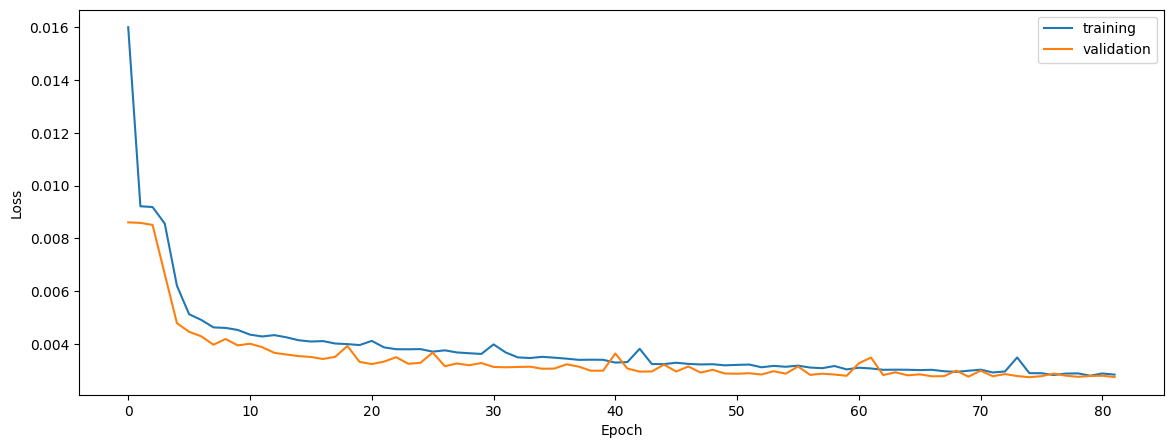

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


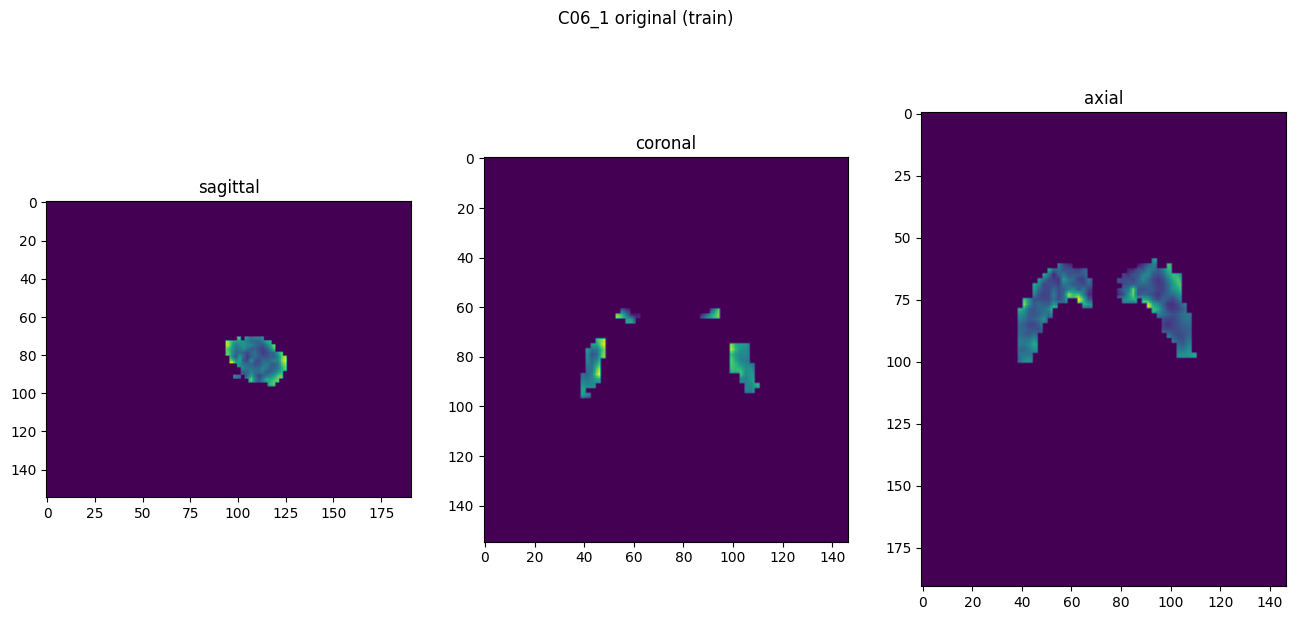

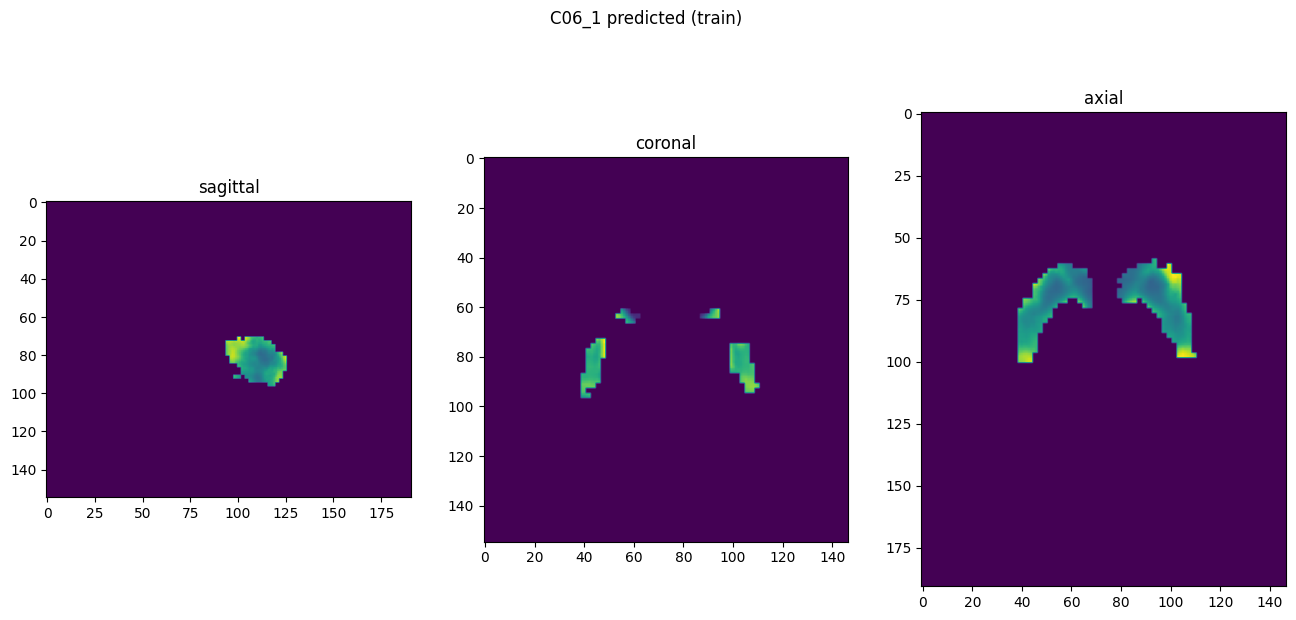

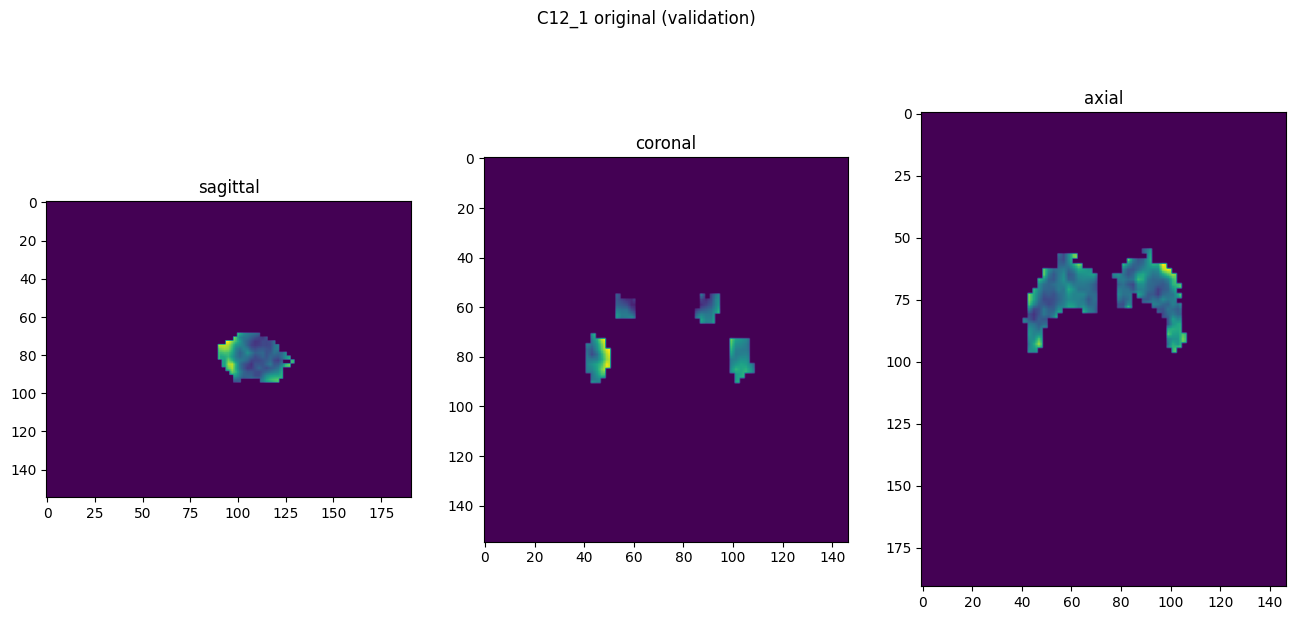

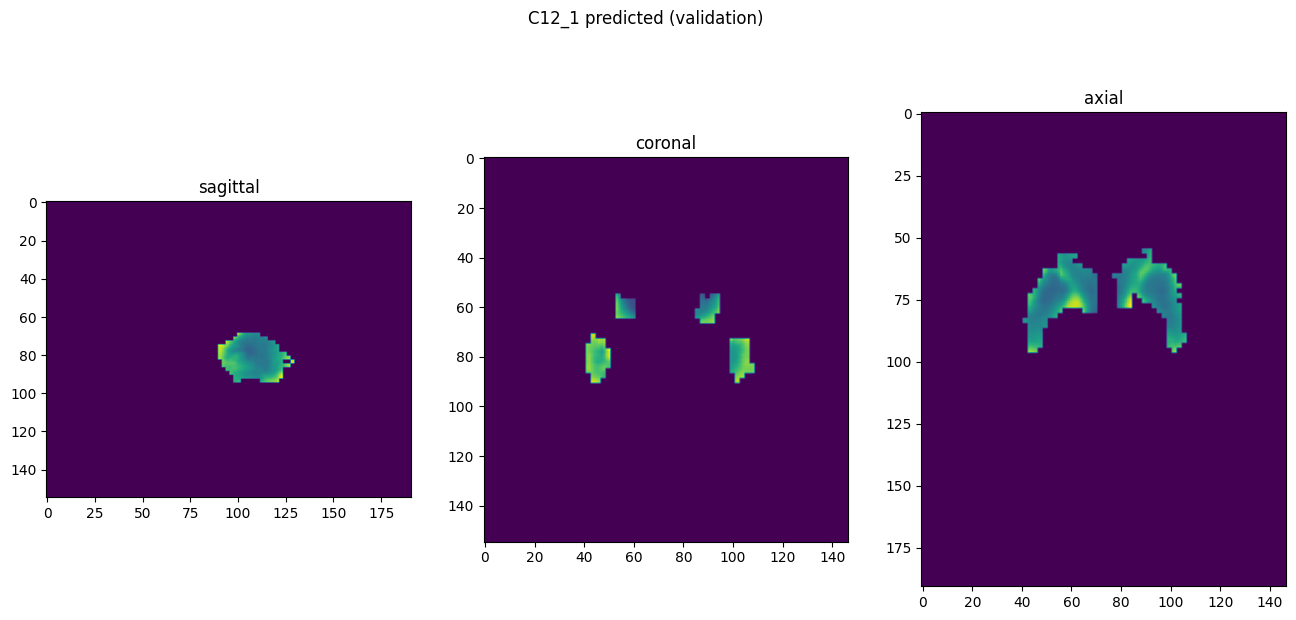

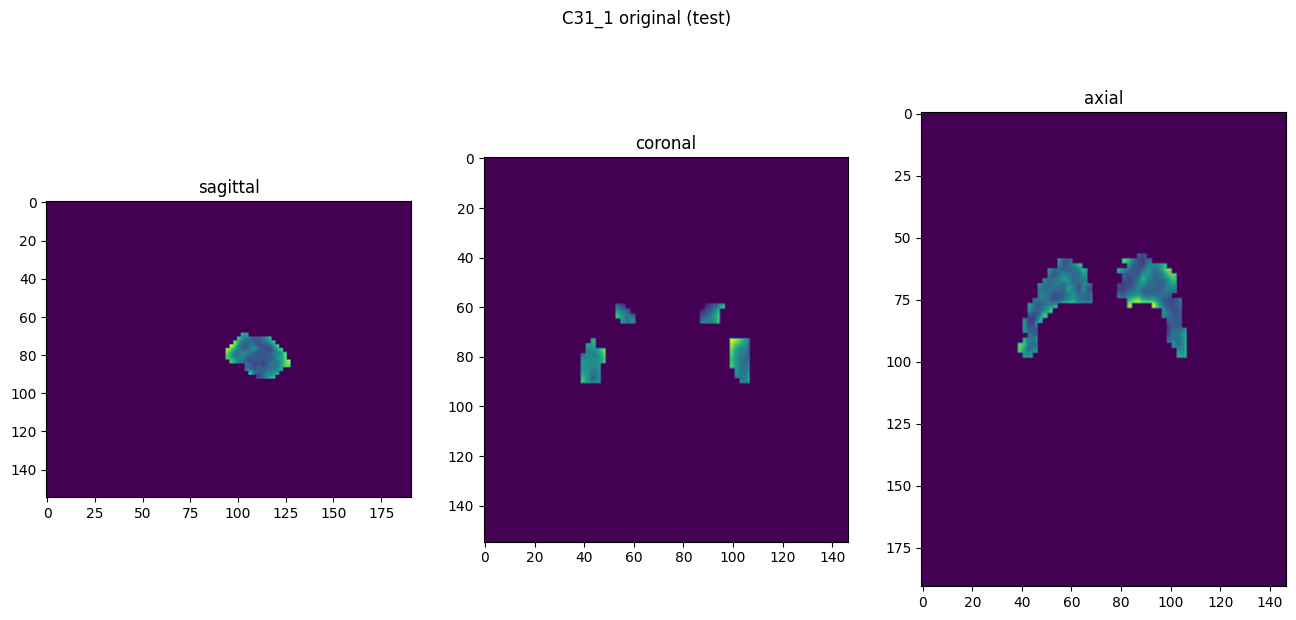

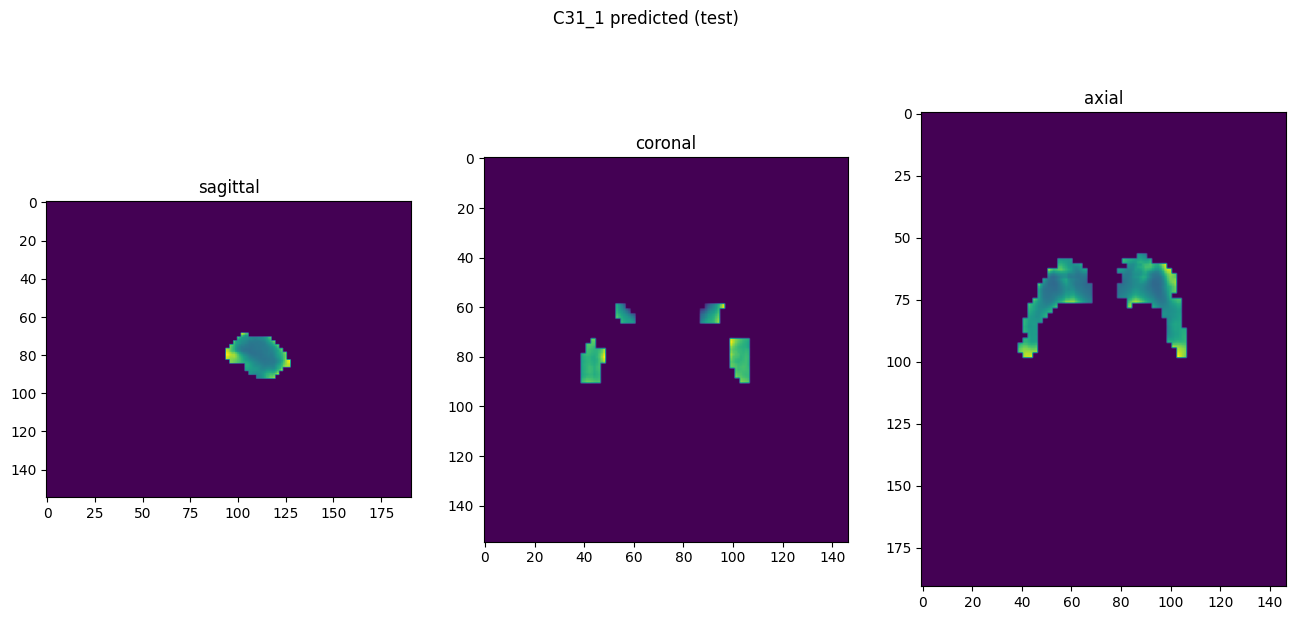

In [10]:
showResults(model, gen, threshold=None, background=False)